In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import time
from xgboost import XGBClassifier
import seaborn as sns

In [2]:
# Загрузка данных
data = pd.read_csv('diabetes.csv')
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [3]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


 1. Исследование Случайного леса

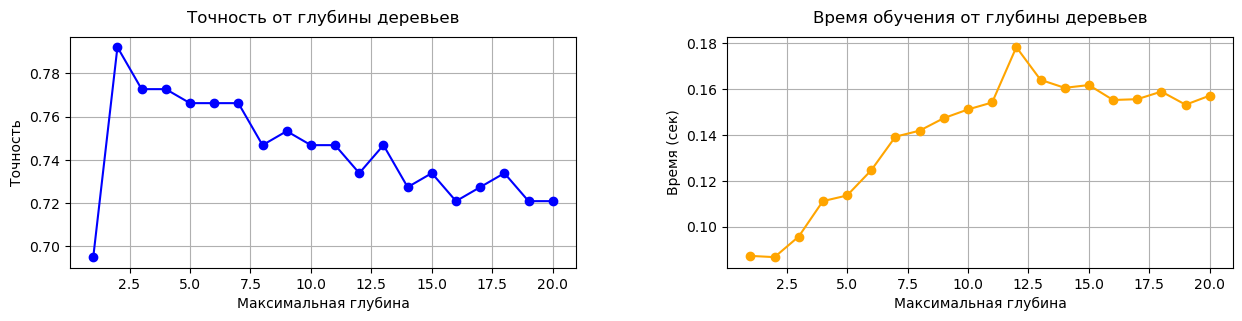

In [8]:
plt.figure(figsize=(15, 12))

# Увеличиваем вертикальные отступы между подграфиками
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# 1.1. Зависимость от глубины деревьев
max_depths = range(1, 21)
accuracy_depth = []
time_depth = []

for depth in max_depths:
    start_time = time.time()
    rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy_depth.append(accuracy_score(y_test, y_pred))
    time_depth.append(time.time() - start_time)

plt.subplot(3, 2, 1)
plt.plot(max_depths, accuracy_depth, marker='o', color='b')
plt.title('Точность от глубины деревьев', pad=10)
plt.xlabel('Максимальная глубина')
plt.ylabel('Точность')
plt.grid()

plt.subplot(3, 2, 2)
plt.plot(max_depths, time_depth, marker='o', color='orange')
plt.title('Время обучения от глубины деревьев', pad=10)
plt.xlabel('Максимальная глубина')
plt.ylabel('Время (сек)')
plt.grid()

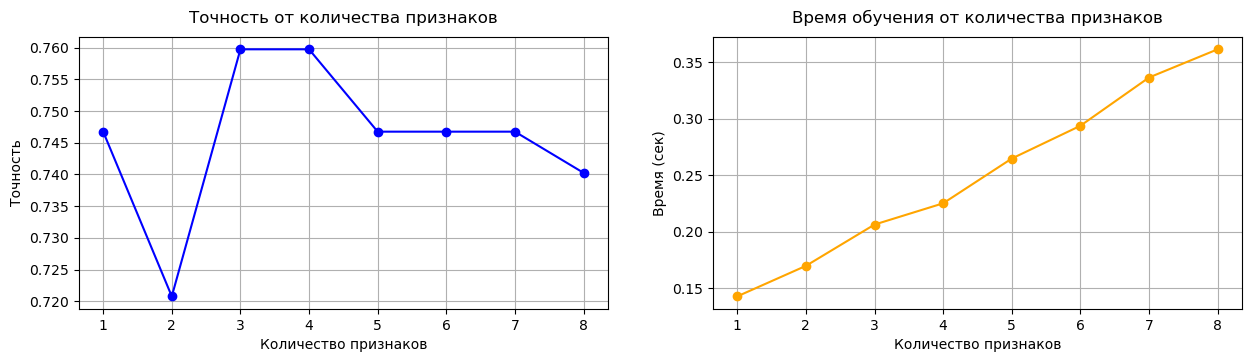

In [17]:
# 1.2. Зависимость от количества признаков 
plt.figure(figsize=(15, 12))

max_features = range(1, X.shape[1]+1)
accuracy_features = []
time_features = []

for features in max_features:
    start_time = time.time()
    rf = RandomForestClassifier(n_estimators=100, max_features=features, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy_features.append(accuracy_score(y_test, y_pred))
    time_features.append(time.time() - start_time)
    
plt.subplot(3, 2, 3)
plt.plot(max_features, accuracy_features, marker='o', color='b')
plt.title('Точность от количества признаков', pad=10)
plt.xlabel('Количество признаков')
plt.ylabel('Точность')
plt.grid()  

plt.subplot(3, 2, 4)
plt.plot(max_features, time_features, marker='o', color='orange')
plt.title('Время обучения от количества признаков', pad=10)
plt.xlabel('Количество признаков')
plt.ylabel('Время (сек)')
plt.grid()

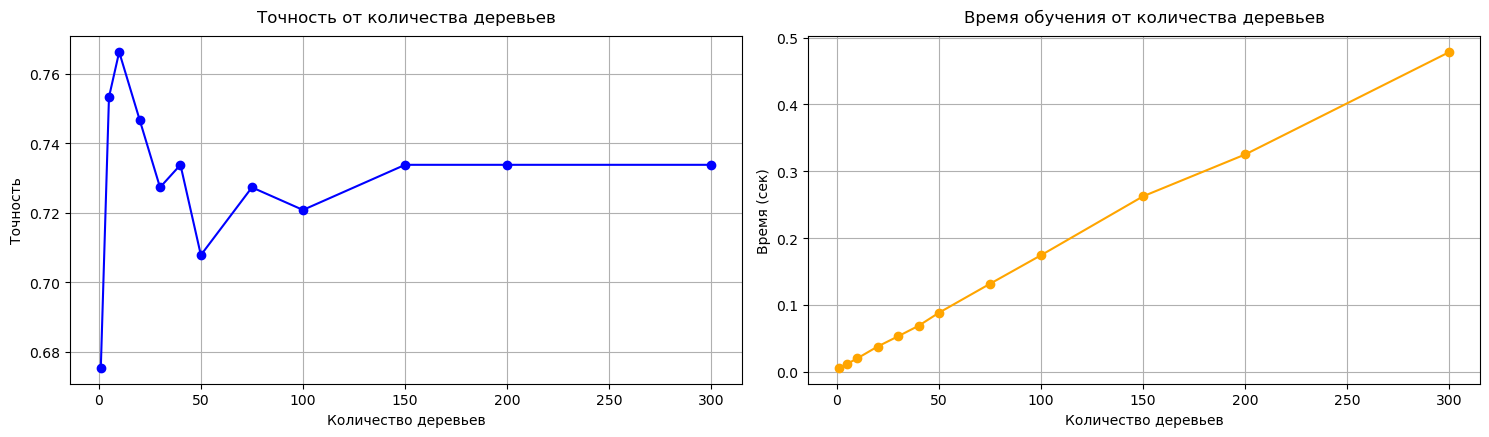

In [18]:
# 1.3. Зависимость от количества деревьев
plt.figure(figsize=(15, 12))

n_estimators = [1, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200, 300]
accuracy_estimators = []
time_estimators = []

for estimators in n_estimators:
    start_time = time.time()
    rf = RandomForestClassifier(n_estimators=estimators, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy_estimators.append(accuracy_score(y_test, y_pred))
    time_estimators.append(time.time() - start_time)

plt.subplot(3, 2, 5)
plt.plot(n_estimators, accuracy_estimators, marker='o', color='b')
plt.title('Точность от количества деревьев', pad=10)
plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.grid()

plt.subplot(3, 2, 6)
plt.plot(n_estimators, time_estimators, marker='o', color='orange')
plt.title('Время обучения от количества деревьев', pad=10)
plt.xlabel('Количество деревьев')
plt.ylabel('Время (сек)')
plt.grid()

plt.tight_layout()
plt.show()

 2. Исследование XGBoost

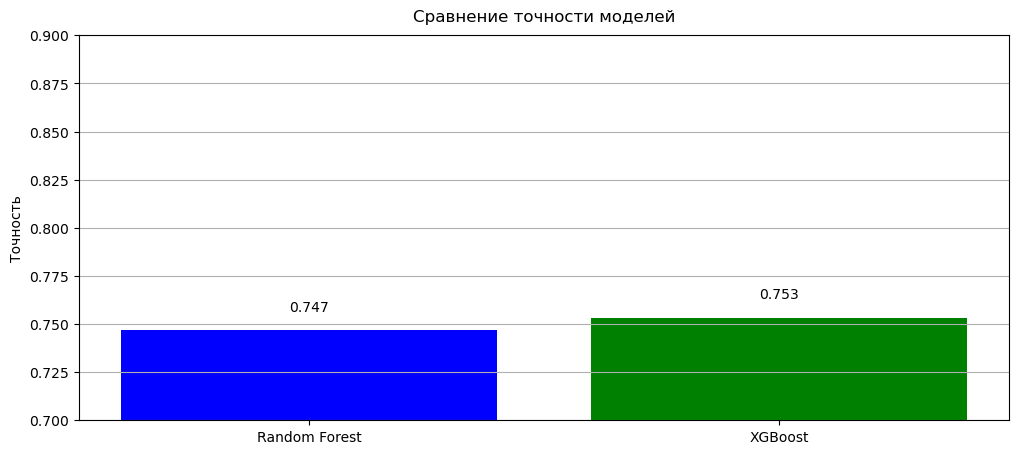

In [21]:
# Подбор оптимальных параметров
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

# Сравнение с моделью случайнго леса
best_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features=5,
    random_state=42
)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

# Визуализация сравнения
plt.figure(figsize=(12, 5))
plt.bar(['Random Forest', 'XGBoost'], [rf_accuracy, xgb_accuracy], color=['blue', 'green'])
plt.title('Сравнение точности моделей', pad=10)
plt.ylabel('Точность')
plt.ylim(0.7, 0.9)
plt.grid(axis='y')
for i, v in enumerate([rf_accuracy, xgb_accuracy]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.show()

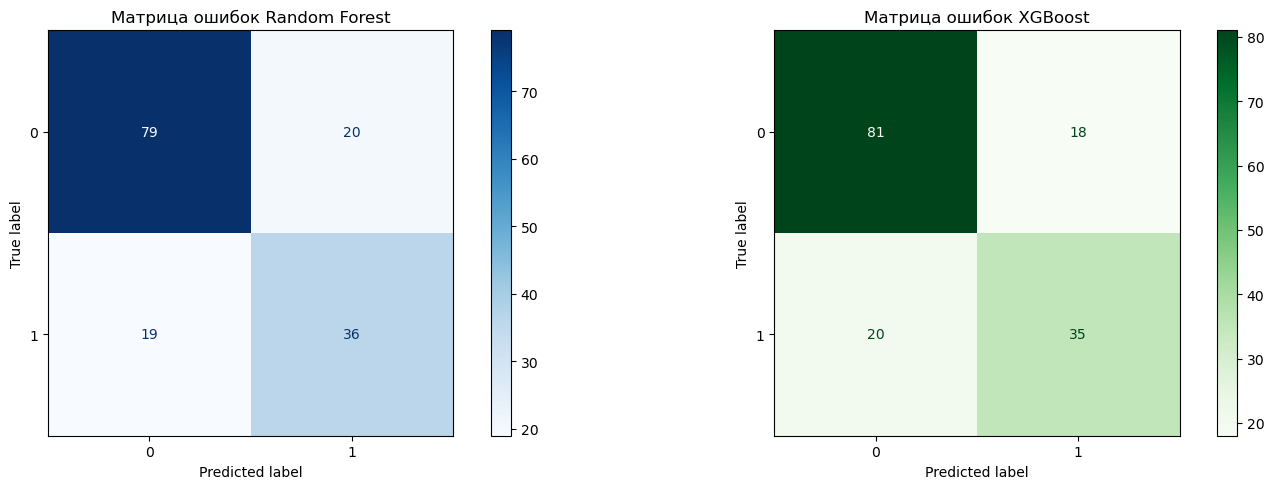

In [22]:
# Матрицы ошибок
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, ax=ax1, cmap='Blues')
ax1.set_title('Матрица ошибок Случайного Леса')
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, ax=ax2, cmap='Greens')
ax2.set_title('Матрица ошибок XGBoost')
plt.tight_layout()
plt.show()

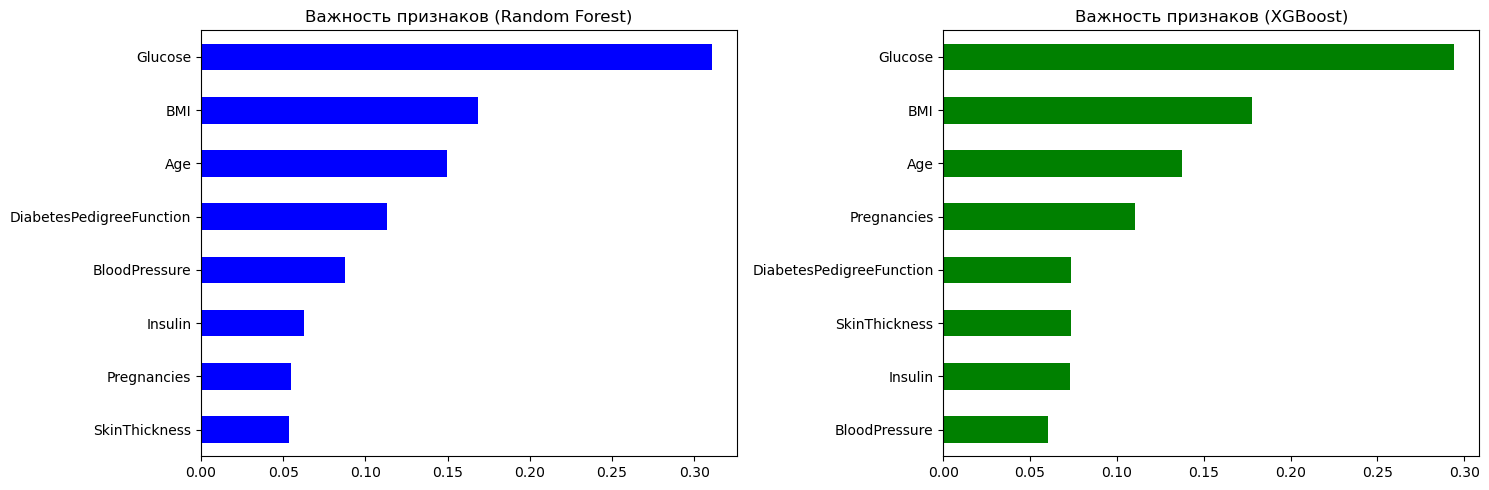

In [23]:
# Важность признаков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

rf_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
rf_importances.sort_values().plot(kind='barh', ax=ax1, color='blue')
ax1.set_title('Важность признаков (Случайный лес)')

xgb_importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
xgb_importances.sort_values().plot(kind='barh', ax=ax2, color='green')
ax2.set_title('Важность признаков (XGBoost)')

plt.tight_layout()
plt.show()

В ходе иследования с XGBoost при подобранных гиперпараметрах модель продемонстрировала высокую точность предсказаний при сравнительно быстром времени обучения, превосходя по этому показателю случайный лес.
Что касается Случайного Леса, его точность действительно улучшается с увеличением глубины деревьев и их количества, однако это приводит к значительному росту вычислительных затрат. Таким образом, хотя случайный лес и способен достигать высоких результатов, его эффективность снижается из-за увеличения времени обучения при масштабировании модели.